# **Data Import :**

In [ ]:
!pip install rasterio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data-20250715T111519Z-1-001.zip to data-20250715T111519Z-1-001.zip


In [ ]:
import zipfile
import os

# مسار الملف المضغوط (تأكد أنك رفعته)
zip_path = "/content/data-20250715T111519Z-1-001.zip"
extract_dir = "/content/WaterSeg_Data"

# فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# التأكد من المحتويات
os.listdir(f"{extract_dir}/data")



['images', 'labels']

# **Preprocessing :**

In [ ]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# Shared file names
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# Read .tif image (12 channels)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # to (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# Read .png image
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)
Train: (244, 128, 128, 12)
Test: (62, 128, 128, 12)


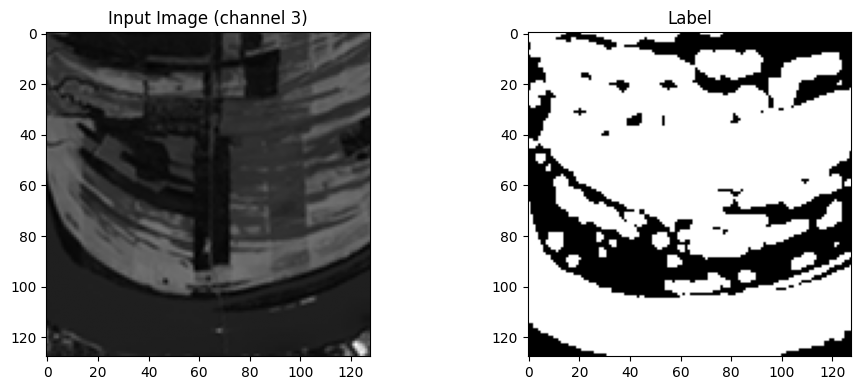

In [ ]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# Shared file names
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# Read .tif image (12 channels)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # to (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# Read .png image
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)

# Normalization (channel-wise min-max)
X_min = np.min(X, axis=(0, 1, 2), keepdims=True)
X_max = np.max(X, axis=(0, 1, 2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

# Labels
Y = (Y > 0).astype(np.uint8)

# 80% Training - 20% Testing
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Train:", train_x.shape)
print("Test:", test_x.shape)

def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')
    axs[0].set_title("Input Image (channel 3)")

    label_img = train_y[index]
    if label_img.shape[-1] == 2:
        label_img = np.argmax(label_img, axis=-1)

    axs[1].imshow(label_img, cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)

In [ ]:
# Normalization (channel-wise min-max)
X_min = np.min(X, axis=(0, 1, 2), keepdims=True)
X_max = np.max(X, axis=(0, 1, 2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

# Labels
Y = (Y > 0).astype(np.uint8)


In [ ]:
# 80% Training - 20% Testing
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Train:", train_x.shape)
print("Test:", test_x.shape)


Train: (244, 128, 128, 12)
Test: (62, 128, 128, 12)


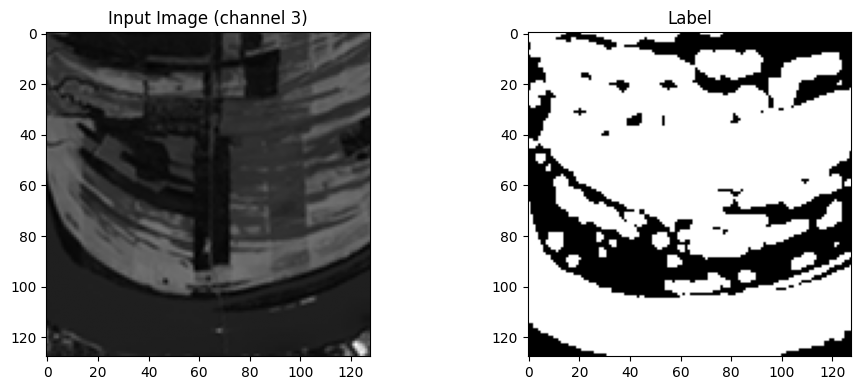

In [ ]:
def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')
    axs[0].set_title("Input Image (channel 3)")

    label_img = train_y[index]
    if label_img.shape[-1] == 2:
        label_img = np.argmax(label_img, axis=-1)

    axs[1].imshow(label_img, cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)


# **U-Net Model :**

In [ ]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # Bridge
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d3) # A final Conv2D layer with (2 classes: water/background).

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 7,788,097 (29.71 MB)

 Trainable params: 7,788,097 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping and reduce_lr & model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint = ModelCheckpoint("U-Net_scratch.h5", monitor="val_accuracy", save_best_only=True)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])


history = model.fit(
    train_x, train_y,
    epochs=80,
    batch_size=8
)


Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 527ms/step - accuracy: 0.7638 - loss: 0.6371
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.8151 - loss: 0.4345
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8590 - loss: 0.3527
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8902 - loss: 0.2976
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9033 - loss: 0.2579
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9119 - loss: 0.2365
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9023 - loss: 0.2585
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8927 - loss: 0.2684
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9147 - loss: 0.2314
Epoch 10/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9093 - loss: 0.2422
Epoch 11/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9124 - loss: 0.2344
Epoch 12/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accur

In [ ]:
loss, acc = model.evaluate(train_x, train_y)
print("Train accuracy:", acc)

loss, acc = model.evaluate(test_x, test_y)
print("Test accuracy:", acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9862 - loss: 0.0336
Train accuracy: 0.9864294528961182
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9711 - loss: 0.1029
Test accuracy: 0.968834638595581


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


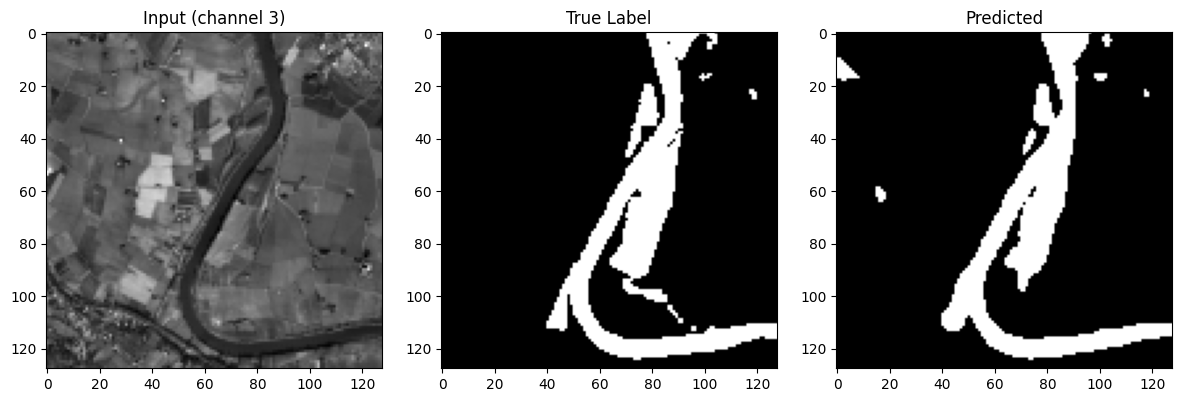

In [ ]:
def show_prediction(index):
    image = test_x[index:index+1]  # (1, 128, 128, 12)

    # True label
    label = test_y[index].squeeze()  # (128, 128)

    # Prediction
    pred = model.predict(image)[0]  # (128, 128, 1)
    pred = (pred > 0.5).astype(np.uint8).squeeze()  # Threshold + remove channel dim

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[0][:,:,3], cmap='gray')  # Channel 3 فقط
    axs[0].set_title("Input (channel 3)")
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title("True Label")
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title("Predicted")
    plt.tight_layout()
    plt.show()

show_prediction(0)


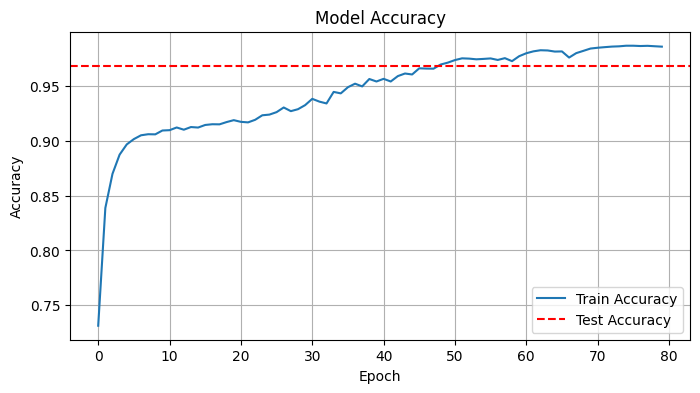

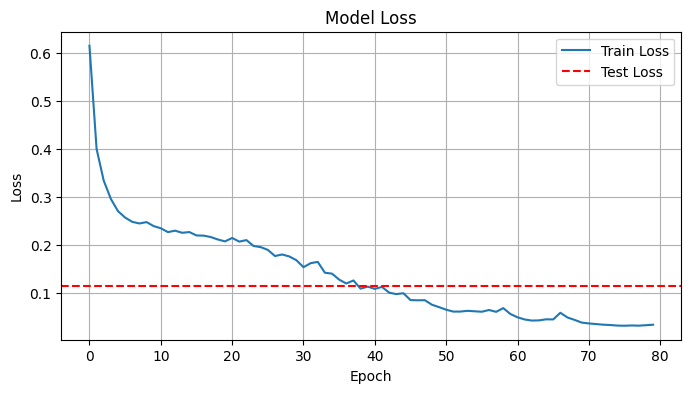

Train Accuracy: 0.9864294528961182
Test Accuracy: 0.968834638595581
Train Loss: 0.03316577151417732
Test Loss: 0.1137249693274498


In [ ]:
train_loss, train_acc = model.evaluate(train_x, train_y, verbose=0)
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)

# 1. Accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Loss plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print values for confirmation
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

#1. Probabilistic Forecasts
y_pred_probs = model.predict(test_x)  # shape = (N, H, W, 1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)  # تحويل إلى 0 أو 1 باستخدام threshold 0.5

# 2. Ground truth
y_true = test_y.astype(np.uint8)  # يفترض أنه بالفعل 0 أو 1

#3. Flatten to 1D to compare each pixel.
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

#4. Evaluation Reports
print("\nClassification Report:\n", classification_report(y_true_flat, y_pred_flat, digits=4))

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
accuracy = accuracy_score(y_true_flat, y_pred_flat)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step

Classification Report:
               precision    recall  f1-score   support

           0     0.9816    0.9781    0.9799    787894
           1     0.9253    0.9367    0.9310    227914

    accuracy                         0.9688   1015808
   macro avg     0.9535    0.9574    0.9554   1015808
weighted avg     0.9690    0.9688    0.9689   1015808

Accuracy:  0.9688
Precision: 0.9253
Recall:    0.9367
F1 Score:  0.9310


In [ ]:
import numpy as np

# A function to calculate the IoU between predicted and actual pixels
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # Special case if both are empty

    iou = intersection / union
    return iou

# Predict the model
y_pred_probs = model.predict(test_x)                      # Output: (N, H, W, 1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)            # Apply threshold to get binary mask

# Ground truth
y_true = test_y.astype(np.uint8)                          # Already binary (0 or 1)

# Flatten the results to 1D
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Calculate IoU
iou_score = compute_iou(y_true_flat, y_pred_flat)
print(f"IoU: {iou_score:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
IoU: 0.8709


In [ ]:
model.save("U-Net_scratch.h5")
from google.colab import files
files.download("U-Net_scratch.h5")
uploaded.keys()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dict_keys(['WaterSeg_Data.zip'])

# **Pre-trained model :  (Preparing the data)**

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_on_images(images, n_components=3):
    """
    Apply PCA to reduce channels from 12 to 3 on a batch of images.

    Parameters:
    - images: numpy array of shape (num_samples, height, width, 12)
    - n_components: number of channels after reduction

    Returns:
    - reduced_images: numpy array of shape (num_samples, height, width, n_components)
    """
    num_samples, height, width, channels = images.shape
    reduced_images = np.zeros((num_samples, height, width, n_components), dtype=np.float32)

    for i in range(num_samples):
        # reshape from (128,128,12) → (128*128, 12)
        flat_img = images[i].reshape(-1, channels)

        # apply PCA on pixel vectors
        pca = PCA(n_components=n_components)
        flat_reduced = pca.fit_transform(flat_img)

        # reshape back to (128,128,n_components)
        reduced_images[i] = flat_reduced.reshape(height, width, n_components)

    return reduced_images


In [ ]:
# نفترض أن train_x هو (N, 128, 128, 12)
train_x_rgb = apply_pca_on_images(train_x, n_components=3)

# نفس الشيء إذا عندك test set
test_x_rgb = apply_pca_on_images(test_x, n_components=3)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return 1 - dice


# **Pre-trained model :  (Model Building & Training)**

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def build_model_with_resnet3(input_shape=(128, 128, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Skip connections
    inputs = base_model.input
    skip1 = base_model.get_layer("conv1_relu").output        # 64x64
    skip2 = base_model.get_layer("conv2_block3_out").output  # 32x32
    skip3 = base_model.get_layer("conv3_block4_out").output  # 16x16
    encoder_output = base_model.get_layer("conv4_block6_out").output  # 8x8

    # Decoder
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding="same", activation='relu')(encoder_output)
    d1 = layers.Concatenate()([d1, skip3])
    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation='relu')(d1)
    d2 = layers.Concatenate()([d2, skip2])
    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(d2)
    d3 = layers.Concatenate()([d3, skip1])
    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(d3)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model

model = build_model_with_resnet3(input_shape=(128,128,3))
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 16,368,513 (62.44 MB)

 Trainable params: 16,337,921 (62.32 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("UNet-REsNet.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.7385 - loss: 0.5971

31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 838ms/step - accuracy: 0.7400 - loss: 0.5947 - learning_rate: 0.0010
Epoch 2/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7972 - loss: 0.4464

31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.7985 - loss: 0.4448 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8099 - loss: 0.4247

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.8102 - loss: 0.4241 - learning_rate: 0.0010
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8166 - loss: 0.4006

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8171 - loss: 0.4001 - learning_rate: 0.0010
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8102 - loss: 0.4120

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8117 - loss: 0.4101 - learning_rate: 0.0010
Epoch 6/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8577 - loss: 0.3320

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8564 - loss: 0.3338 - learning_rate: 0.0010
Epoch 7/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8519 - loss: 0.3342

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8522 - loss: 0.3343 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8555 - loss: 0.3458 - learning_rate: 0.0010
Epoch 9/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8802 - loss: 0.2743

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8795 - loss: 0.2759 - learning_rate: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8484 - loss: 0.3465 - learning_rate: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8517 - loss: 0.3307 - learning_rate: 0.0010
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8571 - loss: 0.3143

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8577 - loss: 0.3134 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8854 - loss: 0.2843 - learning_rate: 0.0010
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8722 - loss: 0.2925

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8724 - loss: 0.2922 - learning_rate: 0.0010
Epoch 15/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8942 - loss: 0.2546

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8940 - loss: 0.2552 - learning_rate: 0.0010
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8739 - loss: 0.2927 - learning_rate: 0.0010
Epoch 17/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9039 - loss: 0.2395

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9030 - loss: 0.2405 - learning_rate: 0.0010
Epoch 18/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8991 - loss: 0.2413

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8988 - loss: 0.2417 - learning_rate: 0.0010
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8932 - loss: 0.2393

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8933 - loss: 0.2396 - learning_rate: 0.0010
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8916 - loss: 0.2621 - learning_rate: 0.0010
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8957 - loss: 0.2419 - learning_rate: 0.0010
Epoch 22/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9154 - loss: 0.1983

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9156 - loss: 0.1984 - learning_rate: 0.0010
Epoch 23/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9181 - loss: 0.1986

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9182 - loss: 0.1984 - learning_rate: 0.0010
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9105 - loss: 0.2164 - learning_rate: 0.0010
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9071 - loss: 0.2232 - learning_rate: 0.0010
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9047 - loss: 0.2258 - learning_rate: 0.0010
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9058 - loss: 0.2297 - learning_rate: 0.0010
Epoch 28/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9330 - loss: 0.1731

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9322 - loss: 0.1742 - learning_rate: 0.0010
Epoch 29/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9187 - loss: 0.1790

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9187 - loss: 0.1796 - learning_rate: 0.0010
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9245 - loss: 0.1889

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9245 - loss: 0.1888 - learning_rate: 0.0010
Epoch 31/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9348 - loss: 0.1600

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9349 - loss: 0.1598 - learning_rate: 0.0010
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9459 - loss: 0.1388

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9457 - loss: 0.1393 - learning_rate: 0.0010
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9367 - loss: 0.1569 - learning_rate: 0.0010
Epoch 34/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9435 - loss: 0.1427

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9435 - loss: 0.1428 - learning_rate: 0.0010
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9301 - loss: 0.1670 - learning_rate: 0.0010
Epoch 36/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9534 - loss: 0.1217

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9533 - loss: 0.1218 - learning_rate: 0.0010
Epoch 37/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9557 - loss: 0.1147

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9555 - loss: 0.1151 - learning_rate: 0.0010
Epoch 38/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9596 - loss: 0.1049

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9596 - loss: 0.1050 - learning_rate: 0.0010
Epoch 39/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9597 - loss: 0.1025

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9597 - loss: 0.1024 - learning_rate: 0.0010
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9323 - loss: 0.1972 - learning_rate: 0.0010
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9141 - loss: 0.2066 - learning_rate: 0.0010
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9230 - loss: 0.1955 - learning_rate: 0.0010
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9308 - loss: 0.1807 - learning_rate: 0.0010
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9466 - loss: 0.1410 - learning_rate: 0.0010
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9497 - loss: 0.1267 - learning_rate: 5.0000e-04
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9576 - loss: 0.1115 - learning_rate: 5.0000e-04
Epoch 47/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9637 - loss: 0.0918

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9637 - loss: 0.0918 - learning_rate: 5.0000e-04
Epoch 48/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9642 - loss: 0.0915

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9642 - loss: 0.0914 - learning_rate: 5.0000e-04
Epoch 49/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9676 - loss: 0.0838

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9675 - loss: 0.0839 - learning_rate: 5.0000e-04
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9677 - loss: 0.0823

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.9677 - loss: 0.0823 - learning_rate: 5.0000e-04


In [ ]:
# تقييم الأداء على بيانات التدريب
train_loss, train_acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", round(train_acc * 100, 2), "%")
print("Train Loss:", round(train_loss, 4))

# تقييم الأداء على بيانات الاختبار
test_loss, test_acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", round(test_acc * 100, 2), "%")
print("Test Loss:", round(test_loss, 4))


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 920ms/step - accuracy: 0.9708 - loss: 0.0747
Train Accuracy: 97.08 %
Train Loss: 0.0743
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9060 - loss: 0.2742
Test Accuracy: 90.19 %
Test Loss: 0.2885


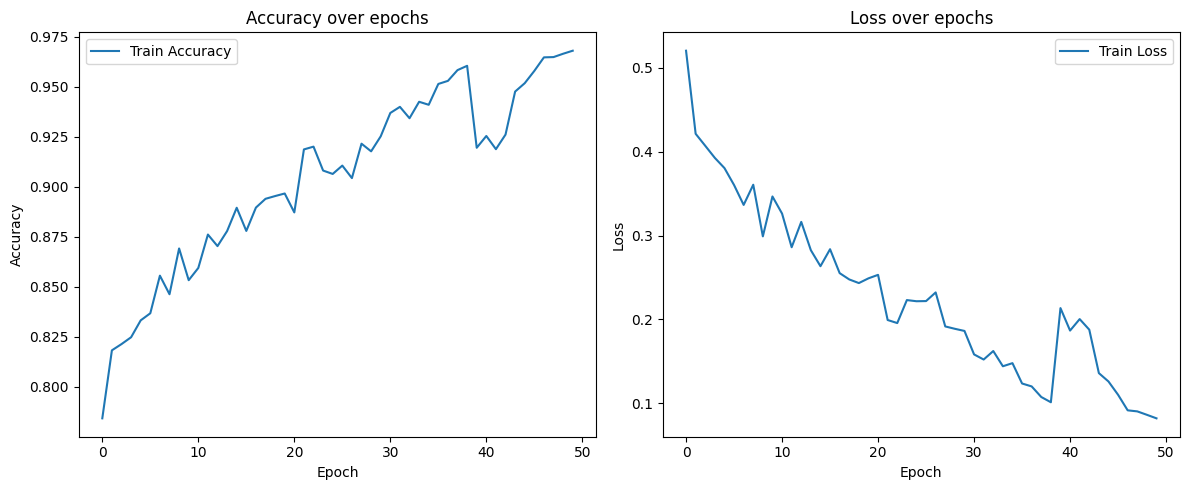

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# منحنى الدقة
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_x_rgb)

y_pred_binary = (y_pred > 0.5).astype(np.uint8)

y_true_flat = test_y.flatten()
y_pred_flat = y_pred_binary.flatten()

print(classification_report(y_true_flat, y_pred_flat, target_names=['Background', 'Tumor']))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
              precision    recall  f1-score   support

  Background       0.92      0.96      0.94    787894
       Tumor       0.83      0.71      0.76    227914

    accuracy                           0.90   1015808
   macro avg       0.87      0.83      0.85   1015808
weighted avg       0.90      0.90      0.90   1015808



In [ ]:
model.save("UNet-REsNet.h5")
from google.colab import files
files.download("UNet-REsNet.h5")
uploaded.keys()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dict_keys(['WaterSeg_Data.zip'])

# **bce_dice_loss**

In [ ]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])


history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("UNet-REsNet-bce.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)

NameError: name 'model' is not defined

In [ ]:
loss, acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", acc)

loss, acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", acc)


In [ ]:
import matplotlib.pyplot as plt

# رسم منحنى الدقة
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("UNet-REsNet-bce.h5")
from google.colab import files
files.download("UNet-REsNet-bce.h5")

# **Adding CNN layer before Pretrained model & Using bce**

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K

# ---------- Step 1: Apply PCA to reduce 12 channels → 3 ----------
def apply_pca_on_images(images, n_components=3):
    num_samples, height, width, channels = images.shape
    reduced_images = np.zeros((num_samples, height, width, n_components), dtype=np.float32)

    for i in range(num_samples):
        flat_img = images[i].reshape(-1, channels)
        pca = PCA(n_components=n_components)
        flat_reduced = pca.fit_transform(flat_img)
        reduced_images[i] = flat_reduced.reshape(height, width, n_components)

    return reduced_images

# Apply PCA
train_x_rgb = apply_pca_on_images(train_x, n_components=3)
test_x_rgb = apply_pca_on_images(test_x, n_components=3)

# ---------- Step 2: Define Dice + BCE Loss ----------
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# ---------- Step 3: Build Model with Pretrained ResNet50 ----------
def build_model_with_resnet3_pca(input_shape=(128, 128, 3)):
    input_tensor = layers.Input(shape=input_shape)

    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
    skip1 = base_model.get_layer("conv1_relu").output
    skip2 = base_model.get_layer("conv2_block3_out").output
    skip3 = base_model.get_layer("conv3_block4_out").output
    encoder_output = base_model.get_layer("conv4_block6_out").output

    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding="same", activation='relu')(encoder_output)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Concatenate()([d1, skip3])

    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation='relu')(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Concatenate()([d2, skip2])

    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Concatenate()([d3, skip1])

    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(d3)
    d4 = layers.BatchNormalization()(d4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    model = models.Model(inputs=input_tensor, outputs=outputs)
    return model

# ---------- Step 4: Compile and Train ----------
model = build_model_with_resnet3_pca(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()


In [ ]:
history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("UNet-ResNet-bceCNNL.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=3),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=8, restore_best_weights=True)
    ]
)


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# -------- Evaluate on Training Data --------
train_loss, train_acc, train_iou = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", train_acc)
print("Train IoU:", train_iou)

# -------- Evaluate on Testing Data --------
test_loss, test_acc, test_iou = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", test_acc)
print("Test IoU:", test_iou)

# -------- Classification Report on Test Data --------
# Step 1: Predict masks
y_pred_test = model.predict(test_x_rgb)
y_pred_test_bin = (y_pred_test > 0.5).astype(np.uint8)  # Threshold

# Step 2: Flatten for classification report
y_true_flat = test_y.flatten()
y_pred_flat = y_pred_test_bin.flatten()

# Step 3: Report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_flat, y_pred_flat, target_names=["Background", "Water"]))


In [ ]:
model.save("UNet-ResNet-bceCNNL.h5")
from google.colab import files
files.download("UNet-ResNet-bceCNNL.h5")

# **Deployment usins Flask API**

In [ ]:
# إيقاف العمليات القديمة وإعادة تشغيل بـ port جديد
import os
import signal
import subprocess
import threading
import time
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok
import numpy as np
from PIL import Image
import tifffile
import cv2
import io
import base64
import json
import h5py
import tensorflow as tf

# 1. إيقاف العمليات القديمة
print("🔄 إيقاف العمليات القديمة...")
try:
    # قتل العمليات اللي بتستعمل port 5000
    result = subprocess.run(['lsof', '-ti:5000'], capture_output=True, text=True)
    if result.stdout.strip():
        pids = result.stdout.strip().split('\n')
        for pid in pids:
            try:
                os.kill(int(pid), signal.SIGKILL)
                print(f"✅ تم إيقاف العملية {pid}")
            except:
                pass
except:
    pass

# إيقاف ngrok tunnels القديمة
try:
    ngrok.kill()
    print("🔌 تم إغلاق ngrok tunnels القديمة")
except:
    pass

time.sleep(2)  # انتظار شوية

# 2. استخدام port جديد
NEW_PORT = 5001

# Configuration
MODEL_PATH_KERAS = "/content/U-Net_scratch.h5"
ALLOWED_EXTENSIONS = {'tif', 'tiff', 'png', 'jpg', 'jpeg'}

# HTML Template (نفس اللي قبل)
HTML_TEMPLATE = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Water Segmentation - Colab</title>
    <style>
        * { margin: 0; padding: 0; box-sizing: border-box; }
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh; padding: 20px;
        }
        .container {
            max-width: 1000px; margin: 0 auto;
            background: rgba(255,255,255,0.95); border-radius: 20px;
            box-shadow: 0 20px 40px rgba(0,0,0,0.1); overflow: hidden;
        }
        .header {
            background: linear-gradient(45deg, #2196F3, #21CBF3);
            color: white; padding: 30px; text-align: center;
        }
        .header h1 { font-size: 2.2em; margin-bottom:10px; font-weight:300; }
        .main-content { padding:30px; }
        .upload-section {
            background:#f8f9fa; border-radius:15px; padding:30px;
            text-align:center; margin-bottom:20px; border:2px dashed #ddd;
            transition: all .3s ease;
        }
        .upload-section:hover { border-color:#2196F3; background:#f0f8ff; }
        .file-input-wrapper { position: relative; display:inline-block; margin:15px 0; }
        .file-input { display:none; }
        .file-input-button {
            background: linear-gradient(45deg, #2196F3, #21CBF3);
            color:white; padding:12px 25px; border-radius:25px;
            border:none; font-size:1em; cursor:pointer; transition:all .3s ease;
        }
        .file-input-button:hover { transform:translateY(-2px); }
        .predict-button {
            background: linear-gradient(45deg, #4CAF50, #45a049);
            color:white; padding:12px 30px; border-radius:25px;
            border:none; font-size:1.1em; cursor:pointer; margin-top:15px;
            transition:all .3s ease;
        }
        .predict-button:hover { transform:translateY(-2px); }
        .predict-button:disabled {
            background:#ccc; cursor:not-allowed; transform:none;
        }
        .loading { display:none; margin:20px 0; }
        .spinner {
            border:3px solid #f3f3f3; border-top:3px solid #2196F3;
            border-radius:50%; width:40px; height:40px;
            animation:spin 1s linear infinite; margin:0 auto;
        }
        @keyframes spin { 0% { transform:rotate(0deg);} 100% { transform:rotate(360deg);} }
        .results { display:none; margin-top:20px; }
        .result-card {
            background:white; border-radius:10px; padding:20px;
            margin:15px 0; box-shadow:0 5px 15px rgba(0,0,0,0.1);
            text-align:center;
        }
        .result-card img { max-width:100%; border-radius:8px; }
        .stats {
            background: linear-gradient(45deg, #FF6B6B, #FF8E53);
            color:white; border-radius:10px; padding:20px; margin:15px 0;
            text-align:center;
        }
        .percentage { font-size:2.5em; font-weight:bold; margin:15px 0; }
        .error {
            background:#ffebee; color:#c62828; padding:15px;
            border-radius:8px; margin:15px 0; border-left:4px solid #c62828;
        }
        .file-info {
            background:#e8f5e8; padding:10px; border-radius:8px;
            margin:10px 0; text-align:left; font-size:.9em;
        }
        .status-info {
            background: #e3f2fd; padding: 15px; border-radius: 8px;
            margin: 10px 0; border-left: 4px solid #2196F3;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>🌊 Water Segmentation AI</h1>
            <p>Running on Google Colab - Port ''' + str(NEW_PORT) + '''</p>
        </div>
        <div class="main-content">
            <div class="status-info">
                <h3>✅ System Status</h3>
                <p>Model: Keras U-Net | Input Shape: 128x128x12 | Status: Ready</p>
            </div>
            <div class="upload-section">
                <h2>📁 Upload TIFF Image</h2>
                <p>Select a 12-channel TIFF file for water detection</p>
                <div class="file-input-wrapper">
                    <input type="file" id="fileInput" class="file-input" accept=".tif,.tiff">
                    <button class="file-input-button" onclick="document.getElementById('fileInput').click()">
                        Choose File
                    </button>
                </div>
                <div id="fileInfo" class="file-info" style="display:none;"></div>
                <button id="predictButton" class="predict-button" onclick="predict()" disabled>
                    🔍 Analyze Water
                </button>
                <div class="loading" id="loading">
                    <div class="spinner"></div>
                    <p>Processing image...</p>
                </div>
            </div>
            <div id="error" class="error" style="display:none;"></div>
            <div id="results" class="results">
                <div class="stats">
                    <h3>Water Detection Results</h3>
                    <div class="percentage" id="waterPercentage">0%</div>
                    <div>Water pixels: <span id="waterPixels">0</span></div>
                    <div>Total pixels: <span id="totalPixels">0</span></div>
                </div>
                <div class="result-card">
                    <h3>🗺️ Segmentation Mask</h3>
                    <img id="maskImage" src="" alt="Water mask">
                </div>
            </div>
        </div>
    </div>
    <script>
        const fileInput = document.getElementById('fileInput');
        const predictButton = document.getElementById('predictButton');
        const loading = document.getElementById('loading');
        const results = document.getElementById('results');
        const error = document.getElementById('error');

        fileInput.addEventListener('change', function(e) {
            const file = e.target.files[0];
            if (file) {
                displayFileInfo(file);
                predictButton.disabled = false;
            }
        });

        function displayFileInfo(file) {
            const fileInfo = document.getElementById('fileInfo');
            const fileSizeMB = (file.size / (1024 * 1024)).toFixed(2);
            fileInfo.innerHTML = `
                <strong>File:</strong> ${file.name}<br>
                <strong>Size:</strong> ${fileSizeMB} MB<br>
                <strong>Type:</strong> ${file.type || 'Unknown'}
            `;
            fileInfo.style.display = 'block';
        }

        async function predict() {
            const file = fileInput.files[0];
            if (!file) { showError('Please select a file first.'); return; }

            loading.style.display = 'block';
            predictButton.disabled = true;
            results.style.display = 'none';
            error.style.display = 'none';

            const formData = new FormData();
            formData.append('file', file);

            try {
                const response = await fetch('/predict', { method: 'POST', body: formData });
                const data = await response.json();
                if (data.success) {
                    displayResults(data);
                } else {
                    showError(data.error || 'Prediction failed.');
                }
            } catch (err) {
                showError('Network Error: ' + err.message);
            } finally {
                loading.style.display = 'none';
                predictButton.disabled = false;
            }
        }

        function displayResults(data) {
            document.getElementById('waterPercentage').textContent = data.water_percentage + '%';
            document.getElementById('waterPixels').textContent = data.water_pixels.toLocaleString();
            document.getElementById('totalPixels').textContent = data.total_pixels.toLocaleString();
            document.getElementById('maskImage').src = 'data:image/png;base64,' + data.mask;
            results.style.display = 'block';
        }

        function showError(message) {
            error.textContent = message;
            error.style.display = 'block';
        }
    </script>
</body>
</html>
'''

# Flask App
app = Flask(__name__)
app.config['MAX_CONTENT_LENGTH'] = 32 * 1024 * 1024

# Global model variable
keras_model = None

# Helper functions
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def prepare_image(image_np):
    """تحضير الصورة للنموذج"""
    if image_np.ndim == 2:
        # Grayscale to RGB to 12 channels
        image_np = np.stack([image_np]*3, axis=-1)
        image_np = np.stack([image_np[:,:,0]] * 12, axis=-1)
    elif image_np.ndim == 3:
        if image_np.shape[0] == 12:
            # (12, H, W) -> (H, W, 12)
            image_np = np.transpose(image_np, (1,2,0))
        elif image_np.shape[2] == 3:
            # RGB -> expand to 12 channels
            channels = [image_np[:,:,i%3] for i in range(12)]
            image_np = np.stack(channels, axis=-1)
        elif image_np.shape[2] == 1:
            image_np = np.repeat(image_np, 12, axis=2)
        elif image_np.shape[2] == 12:
            pass  # Already correct
        else:
            raise ValueError(f"Unsupported channels: {image_np.shape}")

    # Normalize
    if image_np.dtype == np.uint8:
        image_np = image_np.astype(np.float32) / 255.0
    elif image_np.dtype == np.uint16:
        image_np = image_np.astype(np.float32) / 65535.0
    else:
        image_np = image_np.astype(np.float32)

    # Min-max normalization
    mn = image_np.min()
    mx = image_np.max()
    if mx > mn:
        image_np = (image_np - mn) / (mx - mn)

    return image_np

def mask_to_base64(mask):
    """تحويل الـ mask إلى base64"""
    pil = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
    buf = io.BytesIO()
    pil.save(buf, format='PNG')
    return base64.b64encode(buf.getvalue()).decode()

def recover_model_from_h5(path):
    """استرجاع النموذج من ملف H5"""
    with h5py.File(path, 'r') as f:
        model_config_str = f.attrs.get('model_config')
        if model_config_str is None:
            raise RuntimeError("No model_config in H5 file")
        config_dict = json.loads(model_config_str)
        model = tf.keras.Model.from_config(config_dict['config'])
        model.load_weights(path)
        return model

def run_inference(image_np):
    """تشغيل الاستنتاج"""
    orig_shape = image_np.shape[:2]

    # Resize to model input size (128x128)
    img = cv2.resize(image_np, (128, 128), interpolation=cv2.INTER_LINEAR)

    # Add batch dimension
    inp = np.expand_dims(img, axis=0)

    # Predict
    pred = keras_model.predict(inp, verbose=0)[0]

    # Process output
    if pred.ndim == 3 and pred.shape[-1] == 1:
        pred = np.squeeze(pred, axis=-1)
    elif pred.ndim == 2:
        pass
    else:
        pred = pred[..., 0]

    # Threshold
    mask = (pred > 0.5).astype(np.uint8)

    # Resize back to original size
    if mask.shape != orig_shape:
        mask = cv2.resize(mask, (orig_shape[1], orig_shape[0]), interpolation=cv2.INTER_NEAREST)

    return mask

# Load model
print(f"🔄 تحميل النموذج من {MODEL_PATH_KERAS}...")
try:
    keras_model = recover_model_from_h5(MODEL_PATH_KERAS)
    print("✅ تم تحميل النموذج بنجاح!")
    print(f"📐 Input Shape: {keras_model.input_shape}")
except Exception as e:
    print(f"❌ فشل تحميل النموذج: {e}")

# Routes
@app.route('/')
def home():
    """الصفحة الرئيسية"""
    return render_template_string(HTML_TEMPLATE)

@app.route('/health')
def health():
    """فحص حالة النظام"""
    return jsonify({
        "status": "running",
        "port": NEW_PORT,
        "model_loaded": keras_model is not None,
        "model_input_shape": keras_model.input_shape if keras_model else None
    })

@app.route('/predict', methods=['POST'])
def predict():
    """التنبؤ بالمياه في الصورة"""
    try:
        if keras_model is None:
            return jsonify({'success': False, 'error': 'Model not loaded'}), 500

        if 'file' not in request.files:
            return jsonify({'success': False, 'error': 'No file uploaded'}), 400

        file = request.files['file']
        if file.filename == '':
            return jsonify({'success': False, 'error': 'Empty filename'}), 400

        if not allowed_file(file.filename):
            return jsonify({'success': False, 'error': 'Unsupported file type'}), 400

        # Read file
        data = file.read()
        if file.filename.lower().endswith(('.tif', '.tiff')):
            image_np = tifffile.imread(io.BytesIO(data))
        else:
            pil = Image.open(io.BytesIO(data))
            image_np = np.array(pil)

        # Prepare and run inference
        image_prepared = prepare_image(image_np)
        mask = run_inference(image_prepared)

        # Calculate statistics
        water_pixels = int(np.sum(mask > 0))
        total_pixels = int(mask.size)
        water_percentage = float((water_pixels / total_pixels) * 100.0)

        # Convert to base64
        mask_b64 = mask_to_base64(mask)

        return jsonify({
            'success': True,
            'water_percentage': round(water_percentage, 2),
            'water_pixels': water_pixels,
            'total_pixels': total_pixels,
            'mask': mask_b64,
            'original_shape': list(mask.shape),
            'model_used': 'keras'
        })

    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return jsonify({'success': False, 'error': str(e)}), 500

# Start server
def run_server():
    app.run(host="0.0.0.0", port=NEW_PORT, debug=False)

print(f"🚀 بدء تشغيل الخادم على المنفذ {NEW_PORT}...")
threading.Thread(target=run_server, daemon=True).start()

# Wait for server to start
time.sleep(3)

# Start ngrok
try:
    public_url = ngrok.connect(NEW_PORT)
    print(f"🌐 Ngrok URL: {public_url}")
    print("✅ التطبيق يعمل بنجاح!")
    print("📱 افتح الرابط أعلاه لتجربة الواجهة")

    # Keep running
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("🛑 تم إيقاف التطبيق")
except Exception as e:
    print(f"❌ خطأ في ngrok: {e}")

🔄 إيقاف العمليات القديمة...
🔌 تم إغلاق ngrok tunnels القديمة
🔄 تحميل النموذج من /content/U-Net_scratch.h5...
✅ تم تحميل النموذج بنجاح!
📐 Input Shape: (None, 128, 128, 12)
🚀 بدء تشغيل الخادم على المنفذ 5001...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://172.28.0.12:5001
INFO:werkzeug:Press CTRL+C to quit


🌐 Ngrok URL: NgrokTunnel: "https://d5f81de08417.ngrok-free.app" -> "http://localhost:5001"
✅ التطبيق يعمل بنجاح!
📱 افتح الرابط أعلاه لتجربة الواجهة


INFO:werkzeug:127.0.0.1 - - [02/Aug/2025 13:29:50] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Aug/2025 13:29:51] "GET /favicon.ico HTTP/1.1" 404 -
/tmp/ipython-input-3040205701.py:300: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
INFO:werkzeug:127.0.0.1 - - [02/Aug/2025 13:30:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Aug/2025 13:30:50] "GET / HTTP/1.1" 200 -
